In [1]:
import os
import pandas as pd
import numpy as np
import torch
import timeit

import cupy as cp
cp.random.seed(12)

#### Portions of this were borrowed and adapted from the
#### cuDF cheatsheet, existing cuDF documentation,
#### and 10 Minutes to Pandas.

In [2]:
import time

import cupy as cp
import cudf
from cuml.neighbors import NearestNeighbors
from cuml.common.device_selection import using_device_type, set_global_device_type, get_global_device_type

# import dask_cudf
# from dask.distributed import Client, wait
# from dask_cuda import LocalCUDACluster



In [3]:
# cluster = LocalCUDACluster(n_workers=1, threads_per_worker=512)
# client = Client(cluster)

In [4]:
# Generate a "coordinate" dataframe
n_points = 400000
#df = cudf.DataFrame()

point_cloud = torch.cuda.FloatTensor(n_points, 3).uniform_()

# df['x'] = point_cloud[:, 0]
# df['y'] = point_cloud[:, 1]
# df['z'] = point_cloud[:, 2]

# Generate random data for the DataFrame
random_data = np.array(point_cloud.cpu())

# Create the cudf.DataFrame
df = cudf.DataFrame(random_data, columns=["X", "Y", "Z"])

In [5]:
# ddf = dask_cudf.from_cudf(df, npartitions=1)
# ddf.head()

# ddf = ddf.persist()

In [6]:
n_neighbors = 16

In [7]:
from cuml.datasets import make_blobs
from time import perf_counter

# # Generate random data for the DataFrame
# random_data2 = np.random.rand(n_points, 3)

# # Create the cudf.DataFrame
# fit_df = cudf.DataFrame(random_data2, columns=["X", "Y", "Z"])

# fit model
model = NearestNeighbors(n_neighbors=n_neighbors)
model.fit(df)

# start_time = perf_counter()

# # get 3 nearest neighbors
# distances_fit, indices_fit = model.kneighbors(fit_df)

# end_time = perf_counter()
# print(f"Average execution time with blobs: {end_time-start_time:.6f} seconds")


start_time = perf_counter()

# get 3 nearest neighbors
distances1, indices1 = model.kneighbors(df)

end_time = perf_counter()
print(f"Average execution time with common data: {end_time-start_time:.6f} seconds")

Average execution time with common data: 0.607689 seconds


In [8]:
# fit_df.shape == df.shape

In [9]:

def autoSearchAlgorithm(df_input):
    # Create a cuML NearestNeighbors model
    nn = NearestNeighbors(n_neighbors=n_neighbors)

    # Compute the Dask DataFrame
    # ddf_computed = ddf.compute()

    # Fit the model with the input data
    nn.fit(df_input)

    start_time = timeit.default_timer()

    # Get the nearest neighbors
    distances2, indices2 = nn.kneighbors(df_input)

    end_time = timeit.default_timer()
    execution_time = end_time - start_time
    print(f"auto Execution time: {execution_time} seconds")
    # print(indices.compute())

    return distances2, indices2, execution_time


In [10]:
distances2, indices2, execution_time_auto = autoSearchAlgorithm(df)

auto Execution time: 0.6179600109999228 seconds


In [11]:
indices1.head() == indices2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [12]:
def rbcSearchAlgorithm(df_input):
    # Create a cuML NearestNeighbors model
    nn2 = NearestNeighbors(n_neighbors=n_neighbors, algorithm='rbc')

    # Fit the model with the input data
    nn2.fit(df_input)

    start_time = timeit.default_timer()

    # Get the nearest neighbors
    distances3, indices3 = nn2.kneighbors(df_input)

    end_time = timeit.default_timer()
    execution_time = end_time - start_time
    print(f"rbc Execution time: {execution_time} seconds")

    return distances3, indices3, execution_time

distances3, indices3, execution_time_rbc = rbcSearchAlgorithm(df)


rbc Execution time: 0.592156710999916 seconds


In [13]:
indices2.head() == indices3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [14]:
def ivfflatSearchAlgorithm(df_input):
    # Create a cuML NearestNeighbors model
    nn3 = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ivfflat')

    # Fit the model with the input data
    nn3.fit(df_input)

    start_time = timeit.default_timer()

    # Get the nearest neighbors
    distances4, indices4 = nn3.kneighbors(df_input)

    end_time = timeit.default_timer()
    execution_time = end_time - start_time
    print(f"ivfflat Execution time: {execution_time} seconds")

    return distances4, indices4, execution_time

distances4, indices4, execution_time_ivfflat = ivfflatSearchAlgorithm(df)

/home/jabl91/miniconda3/envs/pointcept_py_3_9/lib/python3.9/site-packages/cuml/internals/api_decorators.py:190: UserWarning: 
  return func(*args, **kwargs)


ivfflat Execution time: 0.9188172210006087 seconds


In [15]:
print(indices3.head() == indices4.head())
print(indices4)

     0     1     2     3     4     5     6     7     8     9     10    11  \
0  True  True  True  True  True  True  True  True  True  True  True  True   
1  True  True  True  True  True  True  True  True  True  True  True  True   
2  True  True  True  True  True  True  True  True  True  True  True  True   
3  True  True  True  True  True  True  True  True  True  True  True  True   
4  True  True  True  True  True  True  True  True  True  True  True  True   

     12    13    14    15  
0  True  True  True  True  
1  True  True  True  True  
2  True  True  True  True  
3  True  True  True  True  
4  True  True  True  True  
            0       1       2       3       4       5       6       7   \
0            0  228230  364330   93003  249293   73734  203422  142002   
1            1  128113  260557  250055  222835  342484  330983  300057   
2            2  366661  235361  262980   94230  208169  313825  114637   
3            3   35740  276378  357180   89674  253087  188626  360212   

In [16]:
import torch
import pointops

def knn_query_pointopsv1(n_neighbors_input, point_cloud_input, n_points_input):
    n_points_tensor = torch.cuda.FloatTensor([n_points_input])

    start_time = timeit.default_timer()

    reference_index, _ = pointops.knn_query(n_neighbors_input, point_cloud_input, n_points_tensor)

    torch.cuda.synchronize()

    reference_index_cpu = reference_index.cpu()

    # print(reference_index)

    end_time = timeit.default_timer()
    execution_time = end_time - start_time
    print(f"C++ PointopsV1 KNN Execution time: {execution_time} seconds")
    # print(reference_index.shape)

    return reference_index_cpu, execution_time

reference_index_cpu, execution_time_pointopsv1 = knn_query_pointopsv1(n_neighbors, point_cloud, n_points)

C++ PointopsV1 KNN Execution time: 0.23516880700026377 seconds


In [17]:
print(type(indices1))
print(type(reference_index_cpu))

# Assuming you have a cuDF DataFrame (cudf_df) and a PyTorch Tensor (torch_tensor)
# Extract the data from the cuDF DataFrame
indices1_data = indices1.to_pandas().values

# Convert the cuDF data to a PyTorch Tensor
torch_indices1_data = torch.tensor(indices1_data).to(torch.int32)

# Compare the content element-wise
are_equal = torch.equal(torch_indices1_data, reference_index_cpu)

if are_equal:
    print("The content of the cuDF DataFrame and PyTorch Tensor is equal.")
else:
    print("The content differs between the cuDF DataFrame and PyTorch Tensor.")

<class 'cudf.core.dataframe.DataFrame'>
<class 'torch.Tensor'>
The content differs between the cuDF DataFrame and PyTorch Tensor.


In [18]:
# Compare element-wise equality
elementwise_equal = torch.eq(torch_indices1_data, reference_index_cpu)

# Find indices where elements are different (i.e., where elementwise_equal is False)
differing_indices = torch.nonzero(~elementwise_equal)


print(differing_indices)
print(torch_indices1_data)
print(reference_index_cpu)

tensor([[ 55298,      5],
        [ 55298,      6],
        [153718,      8],
        [153718,      9],
        [299987,      8],
        [299987,      9]])
tensor([[     0, 228230, 364330,  ..., 183823, 257716, 354114],
        [     1, 128113, 260557,  ...,  66253, 216443, 353424],
        [     2, 366661, 235361,  ..., 127867,  44355, 171986],
        ...,
        [399997, 313020, 191319,  ..., 366728, 337190, 152214],
        [399998, 203918,  38125,  ...,  80804, 196779,  13995],
        [399999, 360466, 333458,  ..., 185964, 385090,   8441]],
       dtype=torch.int32)
tensor([[     0, 228230, 364330,  ..., 183823, 257716, 354114],
        [     1, 128113, 260557,  ...,  66253, 216443, 353424],
        [     2, 366661, 235361,  ..., 127867,  44355, 171986],
        ...,
        [399997, 313020, 191319,  ..., 366728, 337190, 152214],
        [399998, 203918,  38125,  ...,  80804, 196779,  13995],
        [399999, 360466, 333458,  ..., 185964, 385090,   8441]],
       dtype=torch.in

In [19]:
import torch
from pointops2 import pointops2 as newerPointOps2

def knn_query_pointopsv2(n_neighbors_input, point_cloud_input, n_points_input):
    n_points_tensor = torch.cuda.FloatTensor([n_points_input])

    start_time = timeit.default_timer()

    reference_index, _ = newerPointOps2.knnquery(n_neighbors_input, point_cloud_input, None, n_points_tensor, n_points_tensor)

    torch.cuda.synchronize()

    reference_index_cpu2 = reference_index.cpu()

    end_time = timeit.default_timer()
    execution_time = end_time - start_time
    print(f"C++ PointopsV2 KNN Execution time: {execution_time} seconds")
    # print(reference_index)

    return reference_index_cpu2, execution_time

reference_index_cpu2, execution_time_pointopsv2 = knn_query_pointopsv2(n_neighbors, point_cloud, n_points)

C++ PointopsV2 KNN Execution time: 0.24528514899975562 seconds


In [20]:
print(type(indices1))
print(type(reference_index_cpu2))

# Assuming you have a cuDF DataFrame (cudf_df) and a PyTorch Tensor (torch_tensor)
# Extract the data from the cuDF DataFrame
indices1_data = indices1.to_pandas().values

# Convert the cuDF data to a PyTorch Tensor
torch_indices1_data = torch.tensor(indices1_data).to(torch.int32)

# Compare the content element-wise
are_equal = torch.equal(torch_indices1_data, reference_index_cpu2)

if are_equal:
    print("The content of the cuDF DataFrame and PyTorch Tensor is equal.")
else:
    print("The content differs between the cuDF DataFrame and PyTorch Tensor.")

<class 'cudf.core.dataframe.DataFrame'>
<class 'torch.Tensor'>
The content differs between the cuDF DataFrame and PyTorch Tensor.


In [21]:
# Compare element-wise equality
elementwise_equal = torch.eq(torch_indices1_data, reference_index_cpu2)

# Find indices where elements are different (i.e., where elementwise_equal is False)
differing_indices2 = torch.nonzero(~elementwise_equal)


print(differing_indices2)
print(torch_indices1_data)
print(reference_index_cpu2)

tensor([[ 55298,      5],
        [ 55298,      6],
        [153718,      8],
        [153718,      9],
        [299987,      8],
        [299987,      9]])
tensor([[     0, 228230, 364330,  ..., 183823, 257716, 354114],
        [     1, 128113, 260557,  ...,  66253, 216443, 353424],
        [     2, 366661, 235361,  ..., 127867,  44355, 171986],
        ...,
        [399997, 313020, 191319,  ..., 366728, 337190, 152214],
        [399998, 203918,  38125,  ...,  80804, 196779,  13995],
        [399999, 360466, 333458,  ..., 185964, 385090,   8441]],
       dtype=torch.int32)
tensor([[     0, 228230, 364330,  ..., 183823, 257716, 354114],
        [     1, 128113, 260557,  ...,  66253, 216443, 353424],
        [     2, 366661, 235361,  ..., 127867,  44355, 171986],
        ...,
        [399997, 313020, 191319,  ..., 366728, 337190, 152214],
        [399998, 203918,  38125,  ...,  80804, 196779,  13995],
        [399999, 360466, 333458,  ..., 185964, 385090,   8441]],
       dtype=torch.in

In [22]:
torch.equal(differing_indices2, differing_indices)

True

In [23]:
# # Create a cuML NearestNeighbors model
# nn4 = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ivfpq')
# # Compute the Dask DataFrame
# ddf_computed = ddf.compute()

# start_time = timeit.default_timer()



# # Fit the model with the input data
# nn4.fit(ddf_computed)

# # Get the nearest neighbors
# distances, indices = nn4.kneighbors(ddf_computed)

# end_time = timeit.default_timer()
# execution_time = end_time - start_time
# print(f"ivfflat Execution time: {execution_time} seconds")

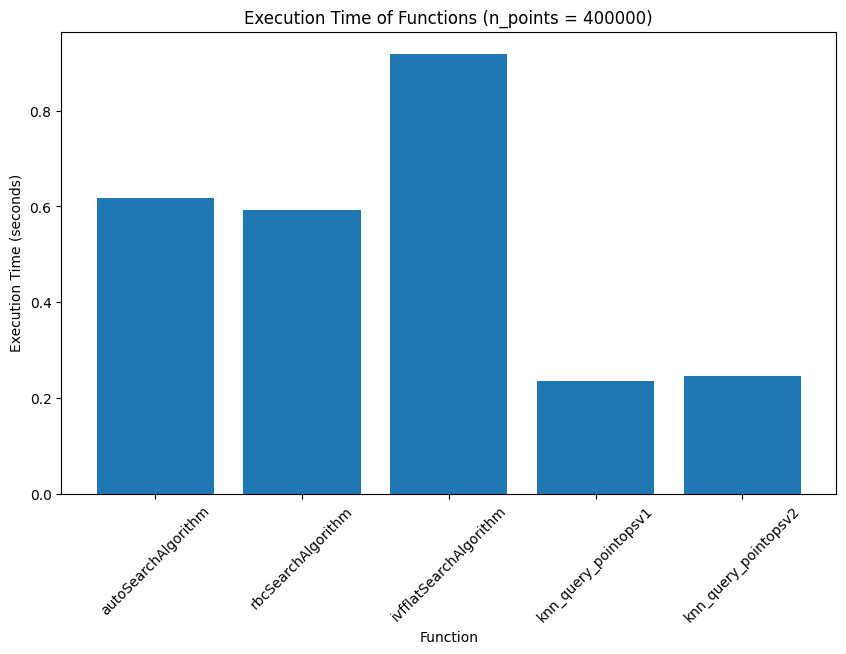

In [24]:
import matplotlib.pyplot as plt

# Execution times of each function
execution_times = [execution_time_auto, execution_time_rbc, execution_time_ivfflat, execution_time_pointopsv1, execution_time_pointopsv2]

# Function names
function_names = ['autoSearchAlgorithm', 'rbcSearchAlgorithm', 'ivfflatSearchAlgorithm', 'knn_query_pointopsv1', 'knn_query_pointopsv2']

# Number of n_points
n_points_used = n_points

# Plotting the execution times
plt.figure(figsize=(10, 6))
plt.bar(function_names, execution_times)
plt.xlabel('Function')
plt.ylabel('Execution Time (seconds)')
plt.title(f'Execution Time of Functions (n_points = {n_points_used})')
plt.xticks(rotation=45)
plt.show()


In [25]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

# List of n_points values
n_points_list = [1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000, 4500000, 5000000, 5500000, 6000000] # Do not use a number above 6000000 if your GPU Memory is 16GB

# Lists to store execution times for each function
execution_times_auto = []
execution_times_rbc = []
execution_times_ivfflat = []
execution_times_pointopsv1 = []
execution_times_pointopsv2 = []

# Loop over n_points values
for n_points in n_points_list:

    print(f"Current n_points: {n_points}")

    # Generate random data for the DataFrame
    point_cloud = torch.cuda.FloatTensor(n_points, 3).uniform_()

    # Generate random data for the DataFrame
    random_data = np.array(point_cloud.cpu())

    # Create the cudf.DataFrame
    df = cudf.DataFrame(random_data, columns=["X", "Y", "Z"])

    # Call the functions and measure execution time
    distances_auto, indices_auto, execution_time_auto = autoSearchAlgorithm(df)
    distances_rbc, indices_rbc, execution_time_rbc = rbcSearchAlgorithm(df)
    distances_ivfflat, indices_ivfflat, execution_time_ivfflat = ivfflatSearchAlgorithm(df)
    reference_index_cpu, execution_time_pointopsv1 = knn_query_pointopsv1(n_neighbors, point_cloud, n_points)
    reference_index_cpu2, execution_time_pointopsv2 = knn_query_pointopsv2(n_neighbors, point_cloud, n_points)

    # Append execution times to the respective lists
    execution_times_auto.append(execution_time_auto)
    execution_times_rbc.append(execution_time_rbc)
    execution_times_ivfflat.append(execution_time_ivfflat)
    execution_times_pointopsv1.append(execution_time_pointopsv1)
    execution_times_pointopsv2.append(execution_time_pointopsv2)

# Create a DataFrame to store the execution times
execution_times_df = pd.DataFrame({
    'n_points': n_points_list,
    'autoSearchAlgorithm': execution_times_auto,
    'rbcSearchAlgorithm': execution_times_rbc,
    'ivfflatSearchAlgorithm': execution_times_ivfflat,
    'knn_query_pointopsv1': execution_times_pointopsv1,
    'knn_query_pointopsv2': execution_times_pointopsv2
})

# Plotting the execution times
plt.figure(figsize=(10, 6))
plt.plot(execution_times_df['n_points'], execution_times_df['autoSearchAlgorithm'], label='autoSearchAlgorithm')
plt.plot(execution_times_df['n_points'], execution_times_df['rbcSearchAlgorithm'], label='rbcSearchAlgorithm')
plt.plot(execution_times_df['n_points'], execution_times_df['ivfflatSearchAlgorithm'], label='ivfflatSearchAlgorithm')
plt.plot(execution_times_df['n_points'], execution_times_df['knn_query_pointopsv1'], label='knn_query_pointopsv1')
plt.plot(execution_times_df['n_points'], execution_times_df['knn_query_pointopsv2'], label='knn_query_pointopsv2')
plt.xlabel('n_points')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison for Different n_points')
plt.legend()
plt.show()


Current n_points: 1000000
auto Execution time: 2.350788859000204 seconds
rbc Execution time: 2.358707299999878 seconds


/home/jabl91/miniconda3/envs/pointcept_py_3_9/lib/python3.9/site-packages/cuml/internals/api_decorators.py:190: UserWarning: 
  return func(*args, **kwargs)


ivfflat Execution time: 1.6709912420001274 seconds
C++ PointopsV1 KNN Execution time: 1.4244443459992908 seconds
C++ PointopsV2 KNN Execution time: 1.3975868659999833 seconds
Current n_points: 2000000
auto Execution time: 6.707301344000371 seconds
rbc Execution time: 6.784420397999384 seconds
ivfflat Execution time: 6.612313283999356 seconds
C++ PointopsV1 KNN Execution time: 5.394502152000314 seconds
C++ PointopsV2 KNN Execution time: 5.40505850900081 seconds
Current n_points: 3000000
auto Execution time: 21.25256814000022 seconds
rbc Execution time: 21.697444933000043 seconds
ivfflat Execution time: 14.999196167000264 seconds
C++ PointopsV1 KNN Execution time: 12.13430927599984 seconds
C++ PointopsV2 KNN Execution time: 12.202676244000031 seconds
Current n_points: 4000000
auto Execution time: 42.366739595999206 seconds
rbc Execution time: 42.54119715700017 seconds
ivfflat Execution time: 35.009925369000484 seconds
C++ PointopsV1 KNN Execution time: 21.169240057000025 seconds
C++ Poin